## Generating data visualisations for Covid Partner Projects

This notebook will allow you to generate a range of data visualisations using new data that comes in on the delivery partners working with REG on Covid projects. The following visualisations can be generated:
- Bar Chart
- Stacked Chart
- Alluvial Graph
- Geographic Plot with Pie Charts 

### The Data

The data required to produce these visualisations is stored on the REG sharepoint here: https://thealanturininstitute.sharepoint.com/:x:/s/ResearchEngineering/EZ0YzNf_NNtPualgQCVX3C4BPTZyB6xIzTBlULx8p6T8Gg?e=WAFjmX
Before new data is added to this document save a copy to the archive folder. Once archived, the new data can be added to the original document and this can be saved with the current month in the file name. 
Save a copy of the new data in Sharepoint and in the GitHub repository under the data folder. The file you save to GitHub must be called 'month_data', with month being the month used in the filed name saved to Sharepoint e.g. 'March_data'.

### Generating the visualisations

Firstly, the following packages need to be loaded.

In [1]:
library(readxl)     
library(lubridate)   
library(tidyr)      
library(dplyr)       
library(ggplot2)    
library(ggalluvial)  

library(tibble)      
library(ggmap)       
library(stringr)    
library(scatterpie)  
library(ggrepel)     
library(ggfittext)   


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.



Next the data must be read and transformed. Before the below script is committed you must change the name of the data document to the correct month. This means you must change 'September_data' to the name of the data file you have saved to GitHub e.g. 'March_data'.

Now you can read the synthetic data and transform it by committing the following:

In [2]:
data <- read_xlsx("./data/September_data.xlsx")

data$Start <- ymd(data$`Start date`)
data$End <- ymd(data$`End date`)

Months <- c("Jan","Feb","Mar","Apr","May","Jun","Jul", "Aug","Sep","Oct","Nov","Dec")

if(! "Jan" %in% colnames(data)){ 
   data <-cbind(data,setNames(lapply(Months, function(x) x=0),Months))
}

Today = today()

data$EffortPerDay <- ifelse(data$End <= rep(Today,nrow(data)), 
                            round(data$Effort/as.numeric(data$End-data$Start),3),
                            round(data$Effort/as.numeric(Today-data$Start),3))

for(i in 1:nrow(data)){
   
   Start <- data[i,"Start"]
   End <- data[i,"End"]
   
   EffortPerDay <- data[i,"EffortPerDay"]
   
   if(Today < Start){

      next
   }

   mStart <- month(Start)
   mEnd <- month(End)
   mToday <- month(Today)
   
   for(m in 1:12){
      
      if(m < mStart | mEnd < m) next
      
      if(mStart == m & mEnd == m){
         
         if(Today < End){
            data[i,Months[m]] <- (day(Today) - day(Start))*EffortPerDay
         }else{
            data[i,Months[m]] <- (day(End) - day(Start))*EffortPerDay
         }
         
         next
         
      }else if(mStart == m & m < mToday) {
         
         data[i,Months[m]] <- (days_in_month(m) - day(Start))*EffortPerDay
         
         next
         
      }
      
      if(m < mToday & m < mEnd){
         data[i,Months[m]] <- days_in_month(m)*EffortPerDay
      }
      
      if(mEnd == m & Today < End){
         data[i,Months[m]] <- day(Today)*EffortPerDay
      }else if(mEnd == m){
         data[i,Months[m]] <- day(End)*EffortPerDay
      }
      
   } 
   
}

d <- pivot_longer(data,cols=all_of(Months),names_to="ProjectMonth",values_to="MonthEffort",
                  names_repair = "unique")

Warning message in with_tz(Sys.time(), tzone):
“Unrecognized time zone ''”


#### Bar Charts: Partner Effort

The following script will produce two bar charts, firstly one without black lines delineating the partner effort by month and then one with black lines delineating the partner projects. 

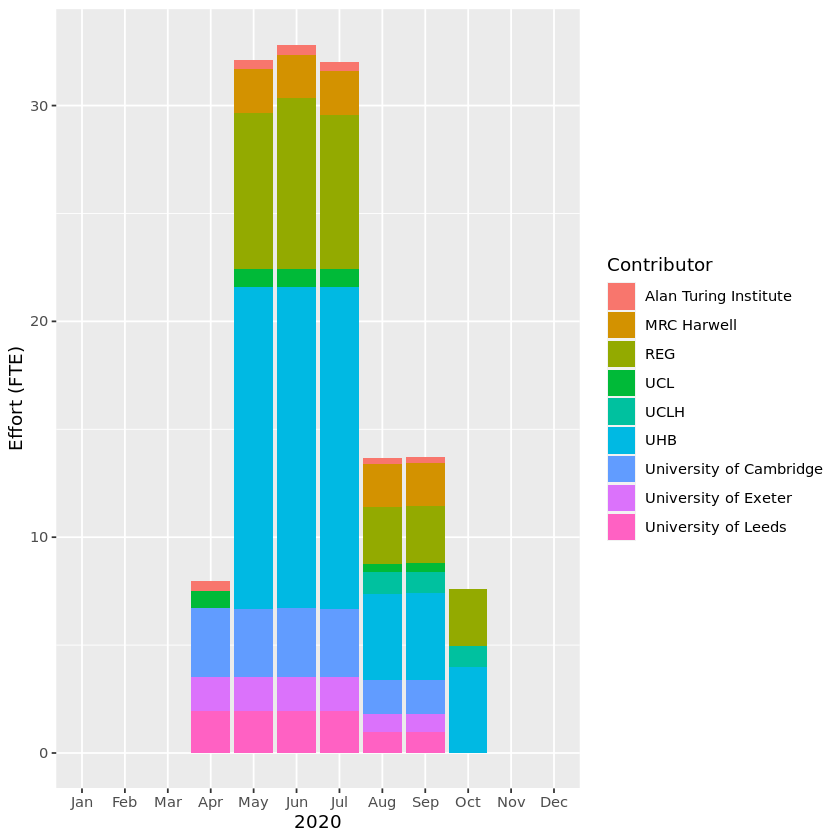

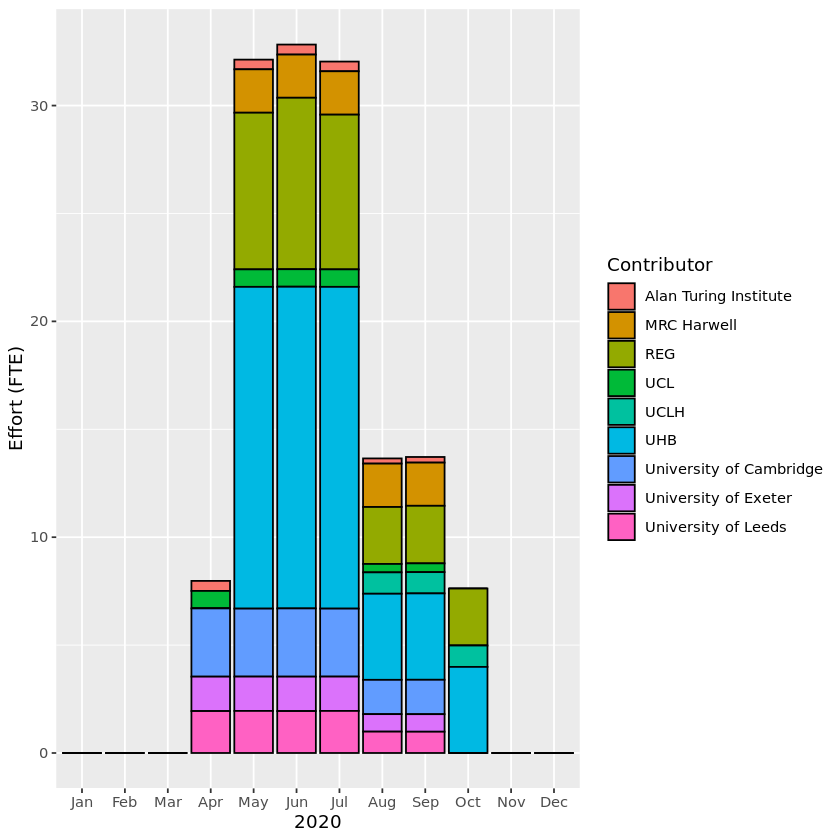

In [3]:
d %>% dplyr::select(Contributor,ProjectMonth,MonthEffort) %>% 
      ggplot(aes(x=factor(ProjectMonth,levels=Months),y=MonthEffort,fill=Contributor)) + 
      geom_col(aes(group=Contributor),position="stack") + xlab("2020") +
      ylab("Effort (FTE)")

d %>% dplyr::select(Contributor,ProjectMonth,MonthEffort,Project)     %>% 
   group_by(ProjectMonth,Contributor)                                 %>% 
   summarise(Effort=sum(MonthEffort),.groups="keep")                  %>% 
   ggplot(aes(x=factor(ProjectMonth,levels=Months),y=Effort,fill=Contributor)) + 
   geom_col(aes(group=Contributor),position="stack",colour="black") + xlab("2020") +
   ylab("Effort (FTE)")

#### Stacked Graphs: 

1. Project monthly effort
The following section of script will produce a stacked graph that shows the overall effort by each project across the project timeline. This can then be normalised using the second section of script. 

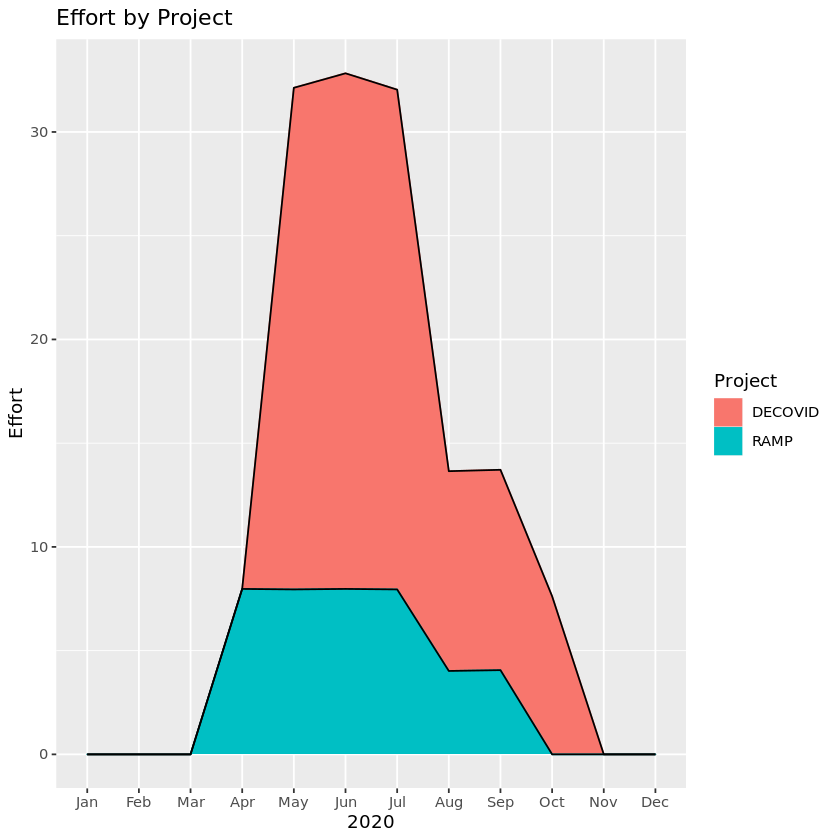

In [4]:
d %>% dplyr::select(Contributor,ProjectMonth,MonthEffort,Project)     %>% 
      group_by(ProjectMonth, Project)                                 %>% 
      summarise(Effort=sum(MonthEffort),.groups="keep")               %>% 
      ggplot(aes(x=factor(ProjectMonth,levels=Months),y=Effort,group=Project,fill=Project)) +
      geom_area(aes(colour=Project)) + geom_line(position="stack",colour="black") +
      xlab("2020") + ggtitle("Effort by Project")

Warning message:
“Removed 10 row(s) containing missing values (geom_path).”


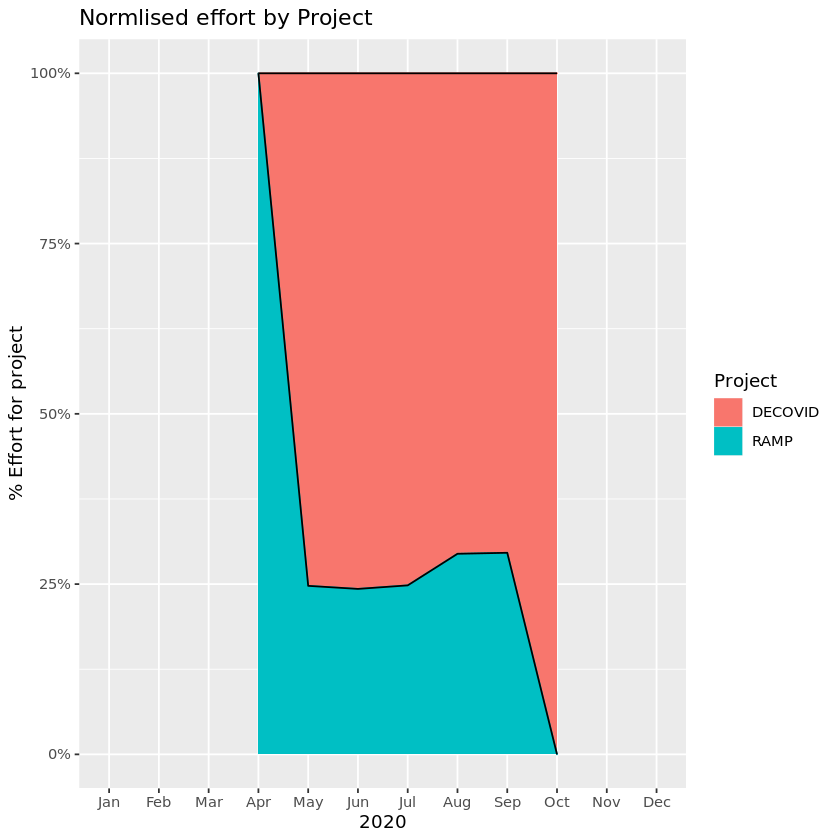

In [5]:
d %>% dplyr::select(Contributor,ProjectMonth,MonthEffort,Project)  %>% 
   group_by(ProjectMonth, Project)                                 %>% 
   summarise(Effort=sum(MonthEffort),.groups="keep")               %>% 
   ggplot(aes(x=factor(ProjectMonth,levels=Months),y=Effort,group=Project,fill=Project)) +
   geom_area(aes(colour=Project),position="fill") + geom_line(position="fill",colour="black") +
   xlab("2020") + ggtitle("Normlised effort by Project") + 
   ylab("% Effort for project") + scale_y_continuous(labels = scales::percent) 


2. Partner monthly effort
The following section of script will produce a stacked graph presenting the overall partner effort across the project timeline. This can then be normalised using the second section of script. 

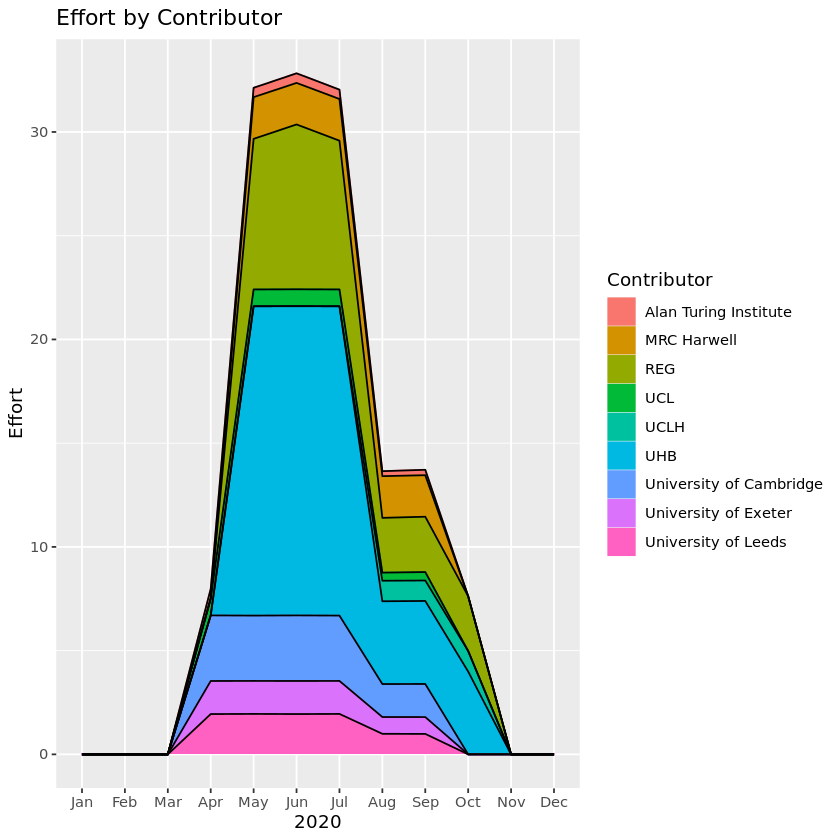

In [6]:
d %>% dplyr::select(Contributor,ProjectMonth,MonthEffort,Project)     %>% 
   group_by(ProjectMonth, Contributor,.drop=FALSE)                    %>% 
   summarise(Effort=sum(MonthEffort),.groups="keep")                  %>% 
   ggplot(aes(x=factor(ProjectMonth,levels=Months),y=Effort,group=Contributor,fill=Contributor)) +
   geom_area(aes(colour=Contributor)) + geom_line(position="stack",colour="black") +
   xlab("2020") + ggtitle("Effort by Contributor")

Warning message:
“Removed 45 row(s) containing missing values (geom_path).”


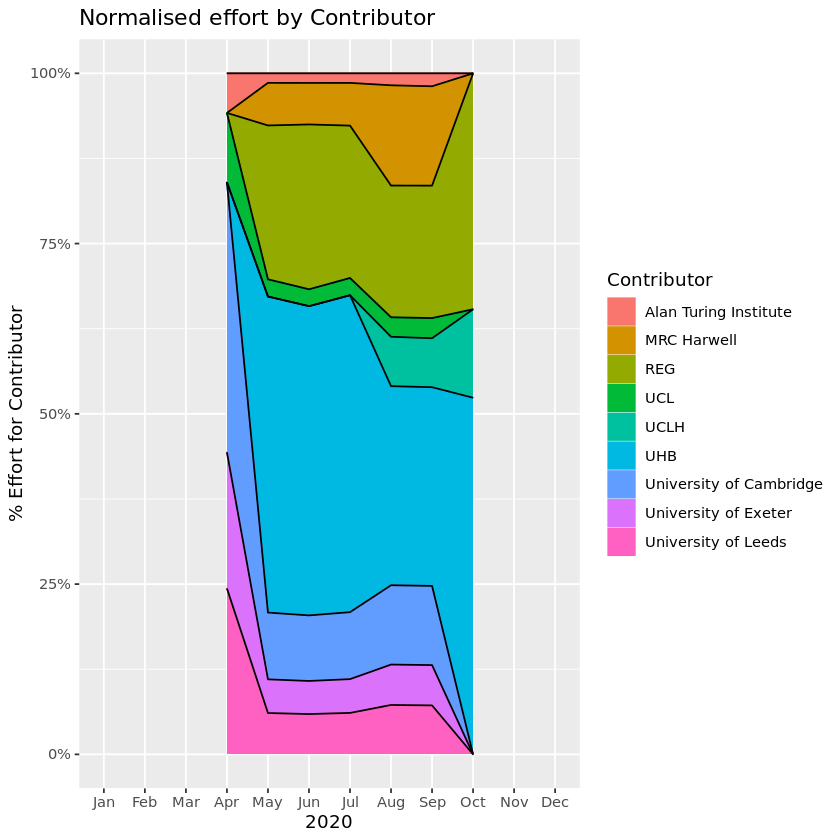

In [7]:
d %>% dplyr::select(Contributor,ProjectMonth,MonthEffort,Project)         %>% 
   group_by(ProjectMonth, Contributor,.drop=FALSE)                        %>% 
   summarise(Effort=sum(MonthEffort),.groups="keep")                      %>% 
   ggplot(aes(x=factor(ProjectMonth,levels=Months),y=Effort,group=Contributor,fill=Contributor)) +
   geom_area(aes(colour=Contributor),position="fill") + geom_line(position="fill",colour="black") +
   xlab("2020") + ggtitle("Normalised effort by Contributor") + 
   ylab("% Effort for Contributor") + scale_y_continuous(labels = scales::percent) 


#### Alluvial Charts

Run the following script to produce an alluvial graph which shows how the partners, tasks and projects overlap. 

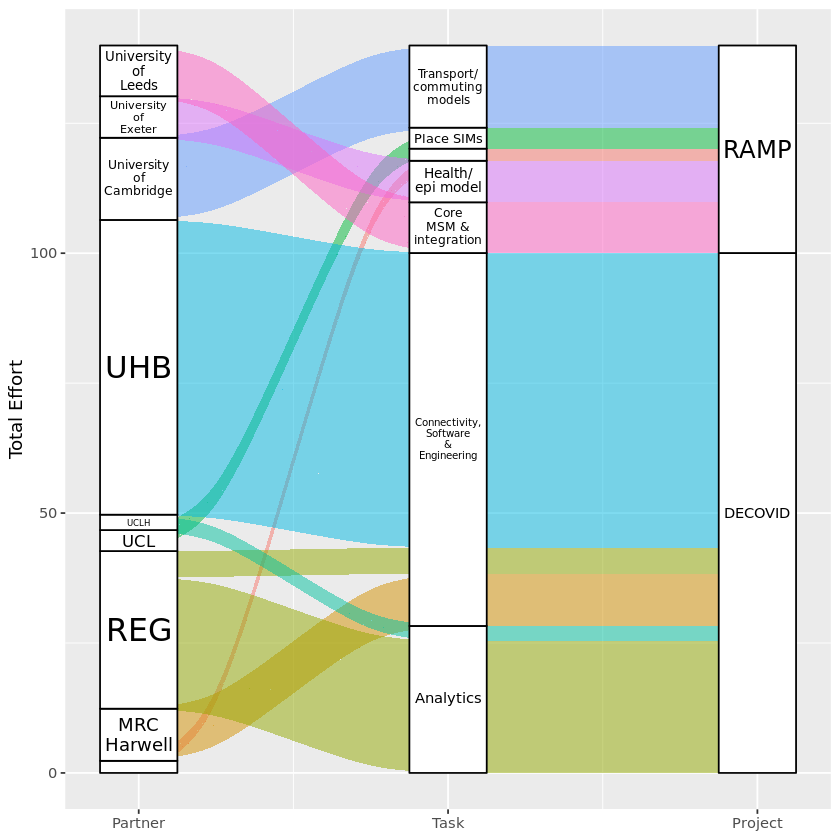

In [8]:
d %>% dplyr::select(Partner=Contributor,Task, Project,MonthEffort)                  %>%
   group_by(Partner, Task, Project, MonthEffort)                                    %>% 
   summarise(TotEffort=sum(MonthEffort), .groups="keep")                            %>% 
   ggplot(aes(axis1=Partner, axis2=Task, axis3=Project,y=TotEffort)) +
   geom_alluvium(aes(fill=Partner), width = 0, reverse = FALSE) +
   guides(fill = FALSE) +
   geom_stratum(width = 1/4, reverse = FALSE) +
   ggfittext::geom_fit_text(aes(label = after_stat(stratum)), 
                 stat = "stratum", outside = TRUE,reflow=TRUE, grow=TRUE, reverse = FALSE, 
                 min.size=2, width = 1/4) + 
   scale_x_continuous(breaks = 1:3, labels = c("Partner", "Task", "Project")) +
   ylab("Total Effort")

#### Geographic plot

The geographic plot will map the location of each partner in the UK. For each partner is a pie chart which is shown the different tasks the partner took part in across the Covid projects. 

##### Shortening partner names
As some of the partners names are too long to fit on the geographic plot without taking up too much space they need to be shortened. This can be done under the section headed #Shortening labels section below. To do this add in the the following code and input the full name then the shortened version of the name of the new delivery partner. See University of Cambridge below as an example:

e$Contributor <- gsub("University of Cambridge","UoC",e$Contributor)

In [9]:
d$lat <- as.numeric(str_split_fixed(d$Contributor_Lat_Long ,",",2)[,1])
d$lon <- as.numeric(str_split_fixed(d$Contributor_Lat_Long,",",2)[,2])

ggmap(ukmap) + geom_point(data=d,aes(x=lon,y=lat))

world = map_data("world", resolution=0)

d %>% dplyr::select(Contributor, Task, MonthEffort, lon, lat)  %>% 
      group_by(Contributor, lon, lat, Task,.drop = FALSE)      %>% 
      summarise(TotEffort=sum(MonthEffort),.groups="drop")     %>% 
      pivot_wider(names_from = Task, values_from=TotEffort, values_fill=0) -> e

# Shortening labels
e$Contributor <- gsub("Alan Turing Institute","ATI",e$Contributor)
e$Contributor <- gsub("University of Exeter","UoE",e$Contributor)
e$Contributor <- gsub("University of Leeds","UoL",e$Contributor)
e$Contributor <- gsub("University of Cambridge","UoC",e$Contributor)

e$Contributor <- factor(e$Contributor)

tasks <- names(e)[4:ncol(e)]

e <- add_column(e,lon2=e$lon,.after=3)
e <- add_column(e,lat2=e$lat,.after=4)

ERROR: Error in ggmap(ukmap): object 'ukmap' not found


##### Manually giving the co-ords an offset

In order to ensure the pie charts are not overlapping, you must set an offset for any new delivery partners. This can be done using the following code but make sure that you change the ATI to the name of the new delivery partners, ensuring you use the shortened version of the name. 

e[e$Contributor == "ATI","lon2"] <- e[e$Contributor == "ATI","lon2"] + offset
e[e$Contributor == "ATI","lat2"] <- e[e$Contributor == "ATI","lat2"] + offset


In [ ]:
offset <- 0.25

e[e$Contributor == "ATI","lon2"] <- e[e$Contributor == "ATI","lon2"] + offset
e[e$Contributor == "ATI","lat2"] <- e[e$Contributor == "ATI","lat2"] + offset

e[e$Contributor == "UCL","lon2"] <- e[e$Contributor == "UCL","lon2"] - offset
e[e$Contributor == "UCL","lat2"] <- e[e$Contributor == "UCL","lat2"] - offset

e[e$Contributor == "UCLH","lon2"] <- e[e$Contributor == "UCLH","lon2"] - offset
e[e$Contributor == "UCLH","lat2"] <- e[e$Contributor == "UCLH","lat2"] + offset

e[e$Contributor == "REG","lon2"] <- e[e$Contributor == "REG","lon2"] + offset
e[e$Contributor == "REG","lat2"] <- e[e$Contributor == "REG","lat2"] - offset

e[e$Contributor == "UoC","lon2"] <- e[e$Contributor == "UoC","lon2"] + offset
e[e$Contributor == "UoC","lat2"] <- e[e$Contributor == "UoC","lat2"] + offset

e[e$Contributor == "UoE","lon2"] <- e[e$Contributor == "UoE","lon2"] - offset
e[e$Contributor == "UoE","lat2"] <- e[e$Contributor == "UoE","lat2"] + offset

e[e$Contributor == "UHB","lon2"] <- e[e$Contributor == "UHB","lon2"] - offset
e[e$Contributor == "UHB","lat2"] <- e[e$Contributor == "UHB","lat2"] - offset

e[e$Contributor == "MRC Harwell","lon2"] <- e[e$Contributor == "MRC Harwell","lon2"] - offset
e[e$Contributor == "MRC Harwell","lat2"] <- e[e$Contributor == "MRC Harwell","lat2"] - offset

e[e$Contributor == "UoL","lon2"] <- e[e$Contributor == "UoL","lon2"] - offset
e[e$Contributor == "UoL","lat2"] <- e[e$Contributor == "UoL","lat2"] - offset


Finally you can commit the following script and generate the plot. 

In [ ]:
ggplot(data=world, aes(x=long, y=lat, group=group)) + 
   geom_polygon(data=world, aes(x=long, y=lat), fill="darkseagreen", color="black") + 
   coord_quickmap(xlim=c(-5.0, 1.68), ylim=c(50,54)) +
   ylab("Latitude") + xlab("Longitude") + 
   geom_point(aes(x=lon,y=lat),data=e, inherit.aes = FALSE) +
   geom_scatterpie(data = e,aes(x=lon2, y=lat2, group=Contributor), cols=tasks ,pie_scale = 3,
                   legend_name ="Tasks",sorted_by_radius = TRUE) +
   geom_label_repel(aes(x=lon2,y=lat2,label= Contributor), data=e,
                    size=2, inherit.aes = FALSE, force=5, alpha=0.5,segment.size = 0) +
   theme(
      panel.background = element_rect(fill="lightsteelblue2"),
      panel.grid.minor = element_line(colour="grey90", size=0.5), 
      panel.grid.major = element_line(colour="grey90", size=0.5), 
      legend.position = "top") 